In [ ]:
import tarfile
import os

extract_dir = "data/extracted/"

for archive in os.listdir("data"):
    if archive.endswith(".gz"):
        archive = f"data/{archive}"
        try:
            with tarfile.open(archive, "r:gz") as tar:
                tar.extractall(path=extract_dir)
                print(f"{archive} extracted to: {extract_dir}")
        
        except Exception as e:
            print(f"Error: {e} extracting {archive}")

In [1]:
import re
import h5py
from joblib import dump, load
from typing import Union, Optional, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

pd.options.display.float_format = '{:.2f}'.format

audio_files_dir = "data/extracted/cv-corpus-20.0-2024-12-06/en/clips/"
char_to_num = {char: idx + 1 for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz ")}
char_to_num['<PAD>'] = 0
n_mfcc = 13

In [2]:
def clean_transcription(text: str):
    """Cleans labels from characters other than letters and spaces, normalizes to lower case."""
    text = re.sub(r'[^\w\s]', "", text)
    return text.lower()


def get_features_and_label(audio_filename: str, raw_label: str):
    """Extracts MFCC representation from data and encodes labels"""
    audio_file_path = f'{audio_files_dir}{audio_filename}'
    audio_time_series, sample_rate = librosa.load(audio_file_path, sr=16000)
    
    # mfcc extraction
    mfcc = librosa.feature.mfcc(y=audio_time_series, sr=sample_rate, n_mfcc=n_mfcc)
    
    # label
    label = np.array([char_to_num.get(char, 28) for char in raw_label], dtype="uint8")

    return mfcc, label
    

def get_data(info_df: pd.DataFrame, n_samples: int = None, data_frac: float = None):
    """Extracts the desired data sample size."""
    X = []
    y = []

    df = info_df.sample(n=n_samples, frac=data_frac, random_state=42)

    for sample in df.itertuples():
        mfcc, label = get_features_and_label(sample.path, sample.clean_sentence)
        X.append(mfcc)
        y.append(label)

    return X, y, df


def sort_data(X, y, idx):
    
    order = sorted(range(len(X)), key=lambda i: X[i].shape[0])
    X_sorted = [X[i] for i in order]
    y_sorted = [y[i] for i in order]
    idxs_sorted = [idx[i] for i in order]

    return X_sorted, y_sorted, idxs_sorted


def save_data(save_path, X, y, df_idxs):

    X, y, df_idxs = sort_data(X, y, df_idxs)

    with h5py.File(save_path, "w") as hf:
        mfcc_group = hf.create_group("mfcc")
        labels_group = hf.create_group("labels")
        
        i = 0
        for mfcc, label, idx in zip(X, y, df_idxs):
            mfcc_group.create_dataset(str(idx), data=mfcc, compression="gzip")
            labels_group.create_dataset(str(idx), data=label, compression="gzip")
            i += 1

    print(f"Saved: {save_path} with {i} samples.")

## Common Voice Dataset

**Common Voice** is an open-source speech dataset created by [Mozilla](https://commonvoice.mozilla.org/) to support the development of speech recognition technologies, especially for underrepresented languages.

### Key Features:
- **Data type**: Audio recordings paired with text transcripts
- **Languages**: Over 100 languages
- **Size**: Hundreds of thousands of hours of voice data contributed by volunteers worldwide
- **Metadata**: Includes information such as age, gender, and accent
- **License**: [CC0 1.0 (Public Domain Dedication)](https://creativecommons.org/publicdomain/zero/1.0/)

### Applications:
- Training and evaluating automatic speech recognition (ASR) models
- Building natural language processing (NLP) tools
- Research in linguistic diversity and accent variation

## Accent Distribution in the Selected Subset

We selected approximately 100,000 random samples from the Common Voice dataset. Below is the distribution of the most common English accents across the entire dataset:

| Accent                                               | Number of Samples |
|------------------------------------------------------|-------------------|
| United States English                                | 250,895           |
| England English                                      | 76,591            |
| India and South Asia (India, Pakistan, Sri Lanka)    | 62,282            |
| Canadian English                                     | 51,552            |
| Non-native speaker, German English                   | 43,152            |
| Australian English                                   | 29,321            |
| Southern African (South Africa, Zimbabwe, Namibia)   | 18,857            |
| Northern Irish                                       | 9,512             |
| Scottish English                                     | 8,480             |
| Irish English                                        | 6,029             |

These accents represent the most frequent English accent categories in the full dataset.

# MFCC - compact representation of audio signal features

Mel Frequency Cepstral Coefficient (MFCC) is a feature extraction method for speech signals that mimics the way the human ear interprets sounds. These data capture the properties of speech signals, such as power, pitch, and the shape of the vocal tract, considering the human ear's varying sensitivity to low and high frequencies. By transforming frequencies to the Mel scale and applying spectral analysis and cosine transformation, MFCC enables the extraction of the most important acoustic features useful for speech recognition.

For example, the first coefficient represents the energy of the entire signal or the average spectral power. It can be seen as a measure of the signal's loudness. The subsequent coefficients represent the overall slope of the spectrum and its modulation. These features distinguish different voices or timbres of sound. Later coefficients delve into more detailed aspects of the spectrum, such as "waviness" or subtle details related to harmonics or noise.

In [5]:
df = pd.read_csv(f"data/extracted/cv-corpus-20.0-2024-12-06/en/train.tsv",
                  sep='\t', low_memory=False)
df = df[(df.down_votes == 0) & (df.up_votes > 1)]
df["clean_sentence"] = df.sentence.apply(clean_transcription)
df = df[df['clean_sentence'].apply(lambda x: bool(re.match("^[a-z ]+$", x)))].reset_index(drop=True)
df["num_characters"] = df.clean_sentence.map(len)
df = df[(df.num_characters <= 110) & (df.num_characters >= 10)]

print(len(df))
df.head(3)

955625


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,clean_sentence,num_characters
0,e1147c4b370eff0cafe6c66348d294ed8d2c3a76cafefd...,common_voice_en_649608.mp3,17f19a4a53c43ec168b35bc4e665c34f35ad25ea6544a3...,It’s just a few blocks to the North.,NaN,2,0,NaN,NaN,NaN,NaN,en,NaN,its just a few blocks to the north,34
1,e1147c4b370eff0cafe6c66348d294ed8d2c3a76cafefd...,common_voice_en_649610.mp3,e72027226311fbf827180d59c1c5fda6ccffdeba56d907...,I was never so tired in my life.,NaN,2,0,NaN,NaN,NaN,NaN,en,NaN,i was never so tired in my life,31
2,e1276b9c6af47dd24d57f219941a08202ceefa7bf01c46...,common_voice_en_18198324.mp3,ebeac089c6e54b7a850857a9289b94916b657eea5b033c...,The noise came from the basement.,NaN,2,0,twenties,male_masculine,United States English,NaN,en,NaN,the noise came from the basement,32


Wav length: 83968


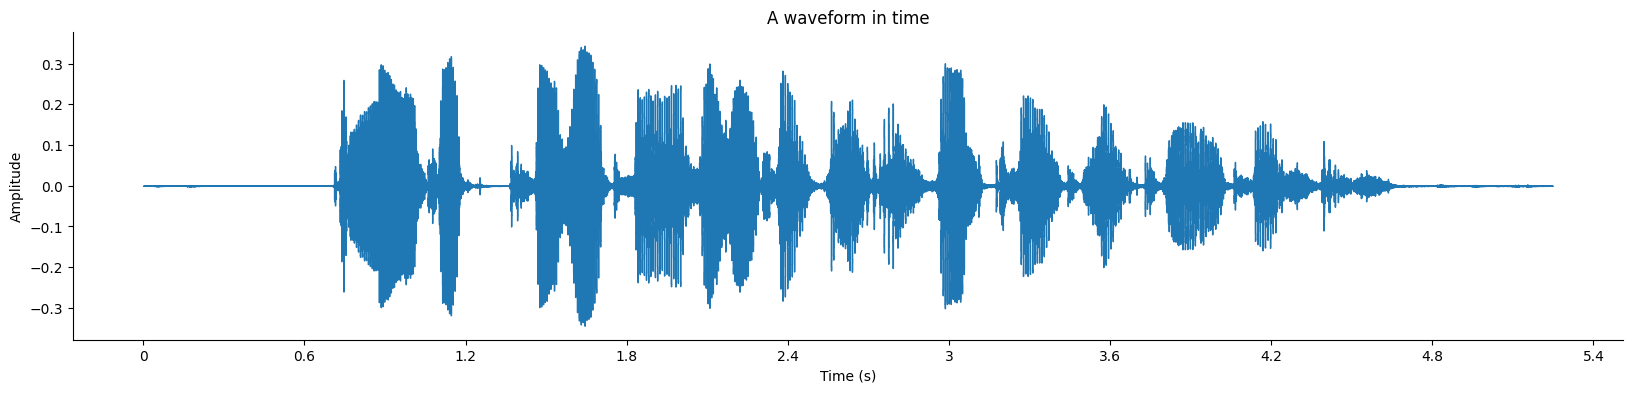

MFCC size: (13, 167)


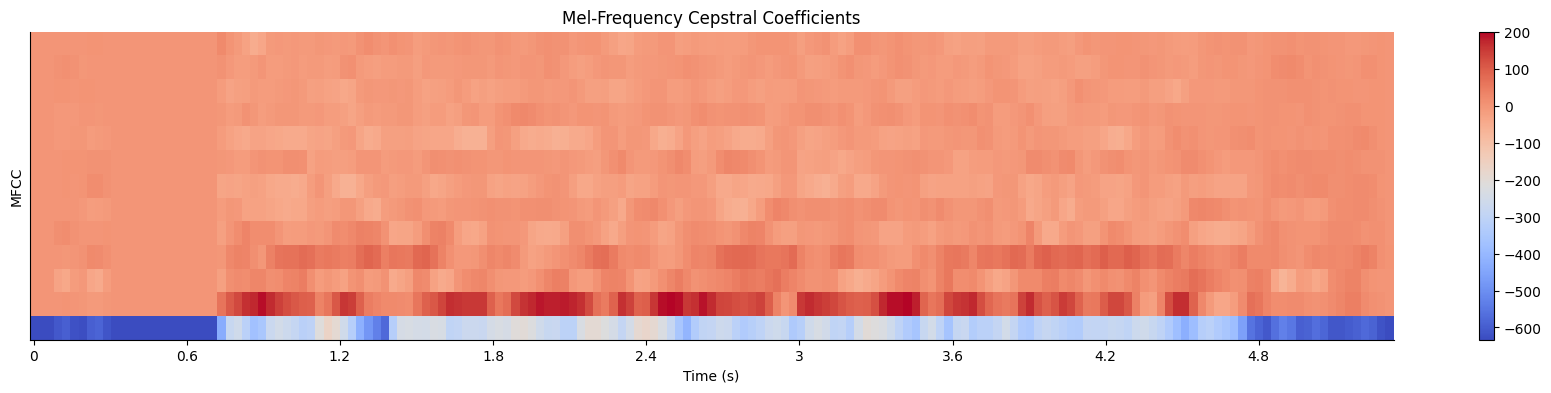

Mel spectrogram shape: (128, 165)


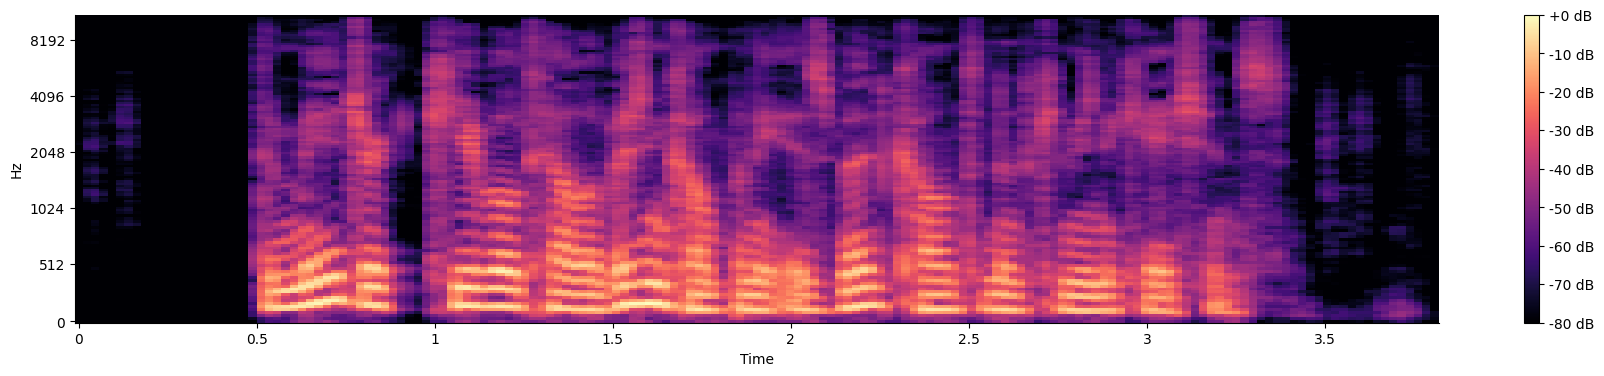

Label:
the major cable television company is midcontinent communications
Encoded label:
[20  8  5 27 13  1 10 15 18 27  3  1  2 12  5 27 20  5 12  5 22  9 19  9
 15 14 27  3 15 13 16  1 14 25 27  9 19 27 13  9  4  3 15 14 20  9 14  5
 14 20 27  3 15 13 13 21 14  9  3  1 20  9 15 14 19] 



In [6]:
for sample in df.sample(1).itertuples():

    # data
    audio_file_path = f'{audio_files_dir}{sample.path}'
    audio_time_series, sample_rate = librosa.load(audio_file_path, sr=16000)
    audio_time_series, _ = librosa.effects.trim(audio_time_series)
    print(f"Wav length: {len(audio_time_series)}")

    plt.figure(figsize=(20, 4))
    librosa.display.waveshow(audio_time_series, sr=sample_rate)
    plt.title("A waveform in time")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # mfcc extraction
    mfcc, transcript = get_features_and_label(sample.path, sample.clean_sentence)
    print(f"MFCC size: {mfcc.shape}")
    
    plt.figure(figsize=(22, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.title("Mel-Frequency Cepstral Coefficients")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC")
    plt.show()

    mel_spectr = librosa.feature.melspectrogram(y=audio_time_series, sr=sample_rate,
                                                n_mels=128, fmax=8000)
    print(f"Mel spectrogram shape: {mel_spectr.shape}")
    
    plt.figure(figsize=(22, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectr, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
    print("Label:")
    print(sample.clean_sentence)
    print("Encoded label:")
    print(transcript, "\n")

Audio(audio_time_series, rate=sample_rate)

# US accent data

Filtering data for pre-testing: only samples with 0 down votes and at least 2 up votes, no shortest or longest transcriptions (to limit padding), only accent marked as United States.

Approximately 100,000 random samples were selected.

In [7]:
df = df[df.accents == "United States English"]
df = df.sample(frac=.5, random_state=42) # random 50% for pre-testing
df.to_csv("selected_usa.csv", index=True)

In [20]:
# the next step after the first experiments with models
usa_more = df[(df.accents == "United States English") & (~df.path.isin(df.path.tolist()))].sample(n=50000, random_state=42)
df = pd.concat([df, usa_more]).reset_index(drop=True)
df.to_csv("selected_usa_175k.csv", index=True)

train_, test = train_test_split(df, test_size=0.15, random_state=42)
train, val = train_test_split(train_, test_size=0.1, random_state=42)

len(train), len(val), len(test)

(134217, 14913, 26318)

### Preparing dataset and saving to h5
Example, same for 4 datasets

In [8]:
# df = pd.read_csv("selected_usa.csv", low_memory=False)
df = pd.read_csv("selected_shuffled.csv", low_memory=False)
train_, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_, test_size=0.1, random_state=42)

len(train), len(val), len(test)

(90322, 10036, 25090)

In [9]:
# just check the original sample rates, all will be normalized
sample_rates = []

for sample in train.itertuples():
    audio_file_path = f'{audio_files_dir}{sample.path}'
    _, sample_rate = librosa.load(audio_file_path, sr=None)
    
    sample_rates.append(sample_rate)

np.mean(sample_rates), np.max(sample_rates), np.min(sample_rates)

(np.float64(41490.798476561635), np.int64(48000), np.int64(32000))

In [9]:
X_train, y_train, train_df = get_data(train, n_samples=len(train))
X_val, y_val, val_df = get_data(val, n_samples=len(val))
X_test, y_test, test_df = get_data(test, n_samples=len(test))

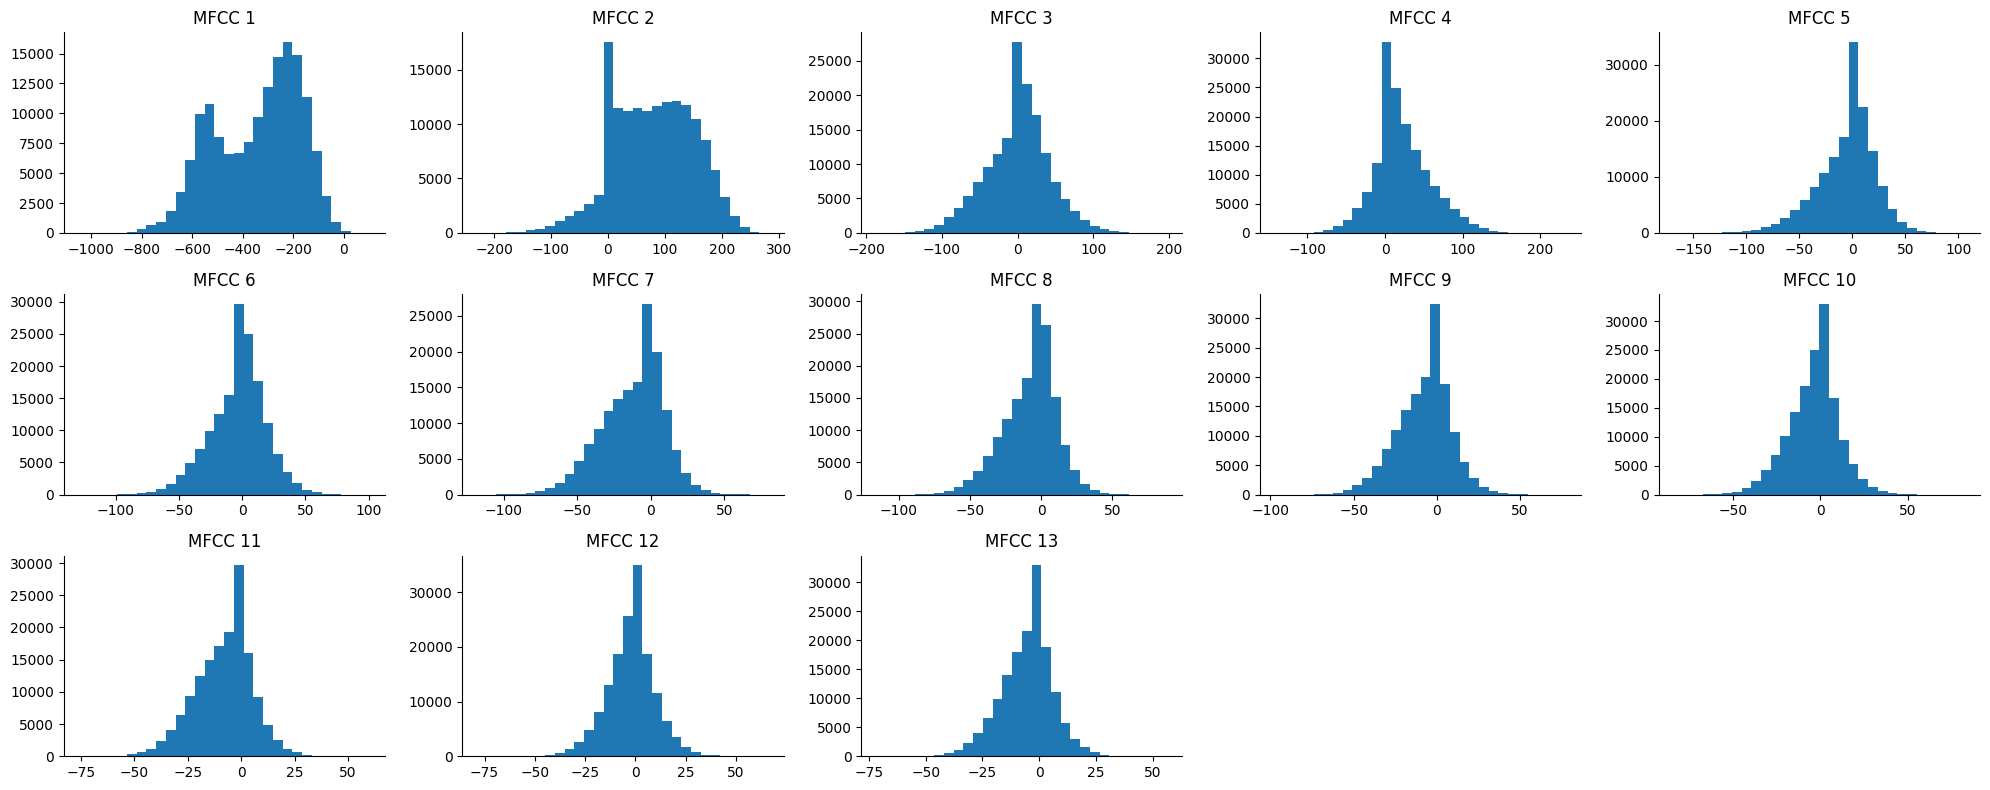

In [10]:
# variables distributions

fig, axes = plt.subplots(3, 5, figsize=(20, 8))

axes = axes.flatten()

for i in range(n_mfcc):
    axes[i].hist(np.vstack([sample.T for sample in X_train])[:, i][::100], bins=30)
    axes[i].set_title(f"MFCC {i+1}")
for i in range(n_mfcc, len(axes)):
    axes[i].set_axis_off()
plt.tight_layout();

In [16]:
scaler = StandardScaler()
scaler.fit(np.vstack([sample.T for sample in X_train])) 

dump(scaler, "scaler_usa.pkl")

['scaler.pkl']

In [24]:
X_train_scaled = [scaler.transform(sample.T) for sample in X_train]
X_val_scaled = [scaler.transform(sample.T) for sample in X_val]
X_test_scaled = [scaler.transform(sample.T) for sample in X_test]

In [ ]:
save_data("data/CommonVoice/train_usa_ext.h5", X_train_scaled, y_train, train_df.index.values)
save_data("data/CommonVoice/val_usa_ext.h5", X_val_scaled, y_val, val_df.index.values)
save_data("data/CommonVoice/test_usa_ext.h5", X_test_scaled, y_test, test_df.index.values)

# Mixed datasets

In [19]:
df = pd.read_csv(f"data/extracted/cv-corpus-20.0-2024-12-06/en/train.tsv",
                  sep='\t', low_memory=False)
df = df[(df.down_votes == 0) & (df.up_votes >= 1)]
df["clean_sentence"] = df.sentence.apply(clean_transcription)
df = df[df['clean_sentence'].apply(lambda x: bool(re.match("^[a-z ]+$", x)))].reset_index(drop=True)
df["num_characters"] = df.clean_sentence.map(len)
df = df[(df.num_characters <= 110) & (df.num_characters >= 10)]
df = df[df.age.notna() & df.gender.notna()]
print(df.shape)
df.accents.value_counts()[:17]

(660658, 15)


accents
United States English                                   220189
England English                                          63957
India and South Asia (India, Pakistan, Sri Lanka)        58283
Canadian English                                         46119
Non native speaker,German English                        43020
Australian English                                       20806
Southern African (South Africa, Zimbabwe, Namibia)       18342
Scottish English                                          5822
Northern Irish                                            5762
New Zealand English                                       5331
Irish English                                             5047
Filipino                                                  3590
United States English,England English                     2417
England English,New Zealand English                       2354
Singaporean English                                       2187
England English,Liverpool English,Lancashire En

In [24]:
# different accents selection (unbalanced)

selected = []

for accent in accents:
    if accent in ['United States English',
                 'England English',
                 'India and South Asia (India, Pakistan, Sri Lanka)',
                 'Canadian English',
                 'Non native speaker,German English',
                 'Australian English',
                 'Southern African (South Africa, Zimbabwe, Namibia)']:
        temp_df = df[df.accents == accent].sample(n=10000, random_state=42)
        selected.append(temp_df)
    else:
        temp_df = df[df.accents == accent]
        selected.append(temp_df)

final = pd.concat(selected).drop(["client_id", "sentence_id", "sentence_domain", "variant", "locale", "segment"], axis=1).reset_index(drop=True)
final.to_csv("unbalanced_dataset.csv", index=True)
final.head(3)

,path,sentence,up_votes,down_votes,age,gender,accents,clean_sentence,num_characters
0,common_voice_en_27034120.mp3,"Thus, the elderly form a distinct group in ter...",2,0,sixties,female_feminine,United States English,thus the elderly form a distinct group in term...,68
1,common_voice_en_19491972.mp3,The band distanced themselves from the song fo...,2,0,sixties,male_masculine,United States English,the band distanced themselves from the song fo...,65
2,common_voice_en_25104834.mp3,Both Hidcote Manor Garden and Kiftsgate Court ...,2,0,thirties,male_masculine,United States English,both hidcote manor garden and kiftsgate court ...,72


In [ ]:
# balanced accents
selected = []
accents = ['United States English',
             'England English',
             'India and South Asia (India, Pakistan, Sri Lanka)',
             'Canadian English',
             'Australian English',
             'Southern African (South Africa, Zimbabwe, Namibia)']

for accent in accents:
    temp_df = df[df.accents == accent].sample(n=18857, random_state=42)
    selected.append(temp_df)
        
final = pd.concat(selected).drop(["client_id", "sentence_id", "sentence_domain", "variant", "locale", "segment"], axis=1).reset_index(drop=True)
final.to_csv("balanced_dataset.csv", index=True)